In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import math

from arms.bernoulli import BernoulliArm
%matplotlib inline
tf.reset_default_graph()

In [2]:
class DeepBandit():
    def __init__(self, num_bandits):
        self.weights = tf.Variable(tf.ones([num_bandits]))
        self.chosen_action = tf.argmax(self.weights,0)
        
        self.reward_holder = tf.placeholder(shape=[1],dtype=tf.float32)
        self.action_holder = tf.placeholder(shape=[1],dtype=tf.int32)
        
        self.responsible_weight = tf.slice(self.weights,self.action_holder,[1])
        self.loss = -(tf.log(self.responsible_weight)*self.reward_holder)
        
        self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        self.update_weights = self.optimizer.minimize(self.loss)
        
        self.e = 0.1
        self.num_bandits = num_bandits
        return
    
    def initialize(self, num_bandits):
        return
    
    def select_arm(self):
        if np.random.rand(1) < self.e:
            action = np.random.randint(self.num_bandits)
        else:
            action = sess.run(self.chosen_action)
        return action

  
    def update(self, chosen_arm, reward):
        if reward == 0:
            reward = -1
        sess.run([self.update_weights,self.responsible_weight,self.weights], feed_dict={self.reward_holder:[reward],self.action_holder:[chosen_arm]})

In [3]:
random.seed(1)
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))
best_arm = np.argmax(means)
print("Best arm is " + str(best_arm))

Best arm is 2


In [4]:
%%time
from testing_framework.tests import *

algo = DeepBandit(n_arms)

init = tf.initialize_all_variables()
with tf.Session() as sess:
    sess.run(init)
    
    results = test_algorithm(algo, arms, 100, 250)
    
dataframe = pd.DataFrame(np.array(results).T,columns=["Sim", "T", "ChosenArm", "Reward", "CumulativeReward"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
CPU times: user 13 s, sys: 1.21 s, total: 14.2 s
Wall time: 11.5 s


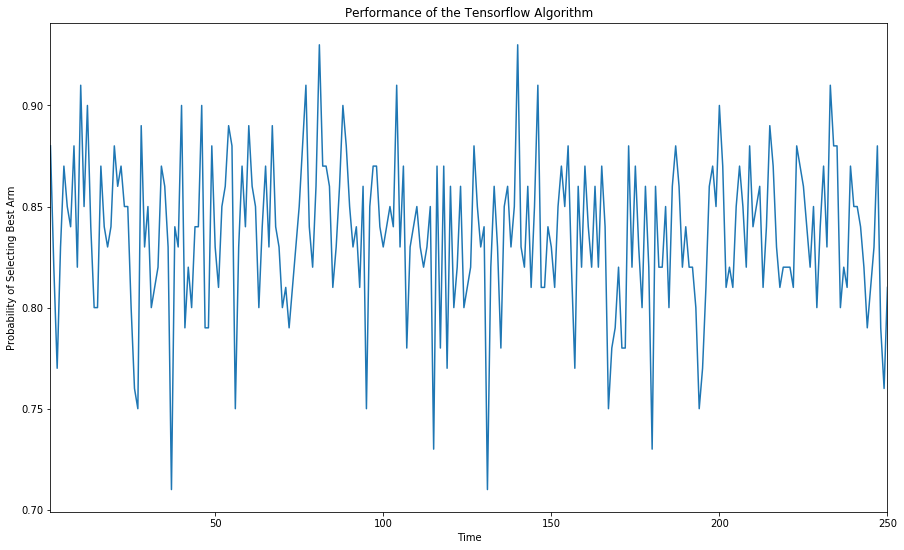

In [5]:
ax = dataframe.groupby("T").mean()['Reward'].plot(figsize=(15,9))
ax.set_title("Performance of the Tensorflow Algorithm")
ax.set_ylabel('Probability of Selecting Best Arm');
ax.set_xlabel('Time');

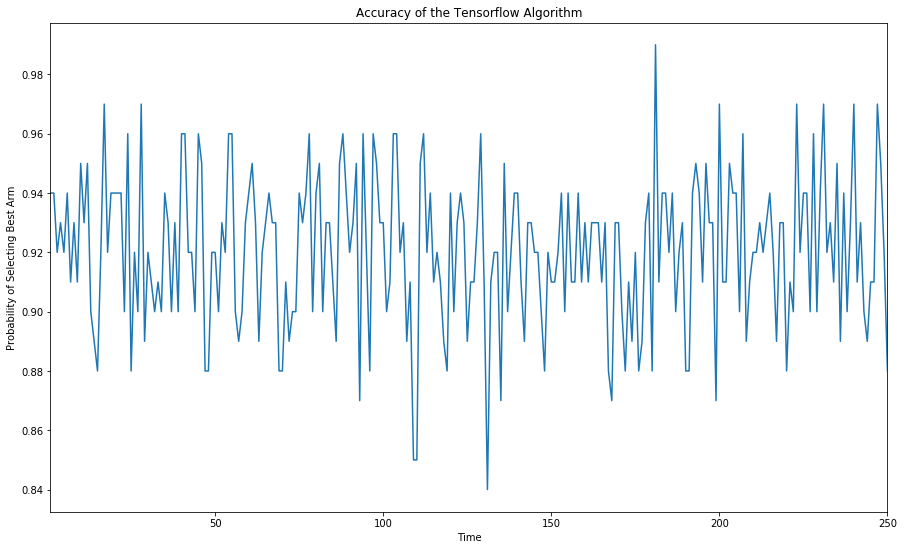

In [6]:
df_grouped = dataframe.groupby(["T","ChosenArm"]).count()/dataframe.Sim.max()
df_grouped = df_grouped.reset_index()
ax = df_grouped[df_grouped['ChosenArm'] == float(best_arm)].set_index('T')['Reward'].plot(figsize=(15,9))
ax.set_title("Accuracy of the Tensorflow Algorithm")
ax.set_ylabel('Probability of Selecting Best Arm');
ax.set_xlabel('Time');

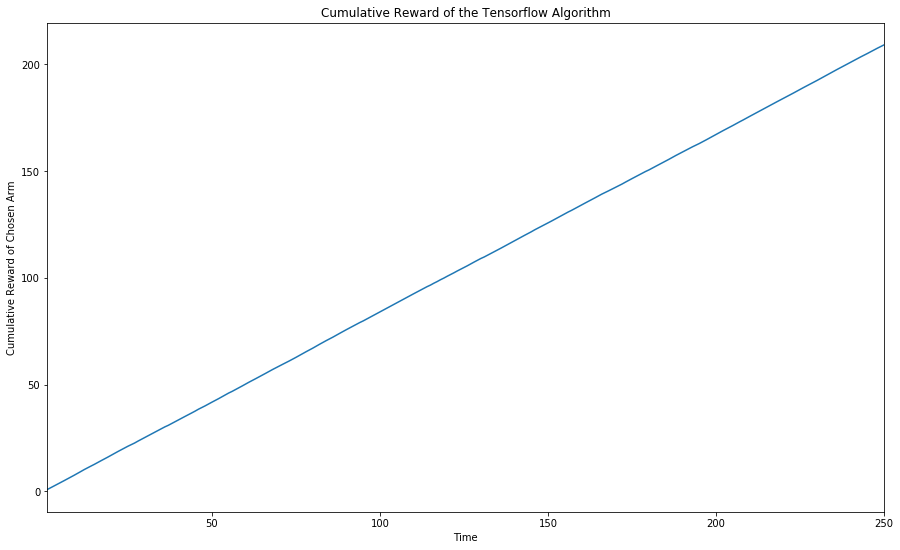

In [7]:
ax = dataframe.groupby("T").mean()['CumulativeReward'].plot(figsize=(15,9))
ax.set_title("Cumulative Reward of the Tensorflow Algorithm")
ax.set_ylabel('Cumulative Reward of Chosen Arm');
ax.set_xlabel('Time');

In [ ]:
dataframe.to_csv("Tensorflow_results.csv",index=None)